In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [34]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.6.0
MPS available: True


# Building a Generative Diffusion Model with WoW Icons

## Project Objectives

In this notebook, I'll document the process of building a generative diffusion model that can create new WoW-style icons. Diffusion models work by gradually adding noise to images and then learning to reverse this process, allowing for high-quality image generation.

## Dataset Information

For this project, I'm using the "CleanIcons-MechagnomeEdition" dataset, specifically version 11.1.0.59347-V4-1, which contains a collection of World of Warcraft icons (upscaled by Mechagnome).
This dataset provides a foundation for exploring diffusion model training on stylistically consistent gaming assets - It may genuinely not work at all, but let's see...

### Dataset Details

- **Name**: CleanIcons-MechagnomeEdition-11.1.0.59347-V4-1
- **Source**: [GitHub - AcidWeb/Clean-Icons-Mechagnome-Edition](https://github.com/AcidWeb/Clean-Icons-Mechagnome-Edition/releases/tag/11.1.0.59347-V4-1)
- **Contents**: World of Warcraft icons
- **Format**: TGA (Truevision Graphics Adapter) image files
- **Features**: High-quality game icons with transparency support

### Implementation Notes

This implementation adapts the diffusion model architecture to work with:

- TGA format images (using PIL for loading)
- Apple Silicon hardware (ensuring MPS device compatibility)
- Custom data loading pipeline for WoW icon processing

### Credits and References

This implementation takes direct reference from ["A Diffusion Model from Scratch in PyTorch"](https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=Rj17psVw7Shg).

The original work references:

- GitHub implementation of [Denoising Diffusion PyTorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Work by Niels Rogge and Kashif Rasul in their [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Academic papers on Diffusion models:
  - [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672) (Nichol & Dhariwal, 2021)
  - [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (Ho et al., 2020)
  - [Diffusion Models Beat GANs on Image Synthesis](https://arxiv.org/abs/2105.05233) (Dhariwal & Nichol, 2021)

I've adapted this implementation to work specifically with TGA format WoW icons on Apple Silicon hardware, modifying the data loading pipeline and ensuring MPS device compatibility.


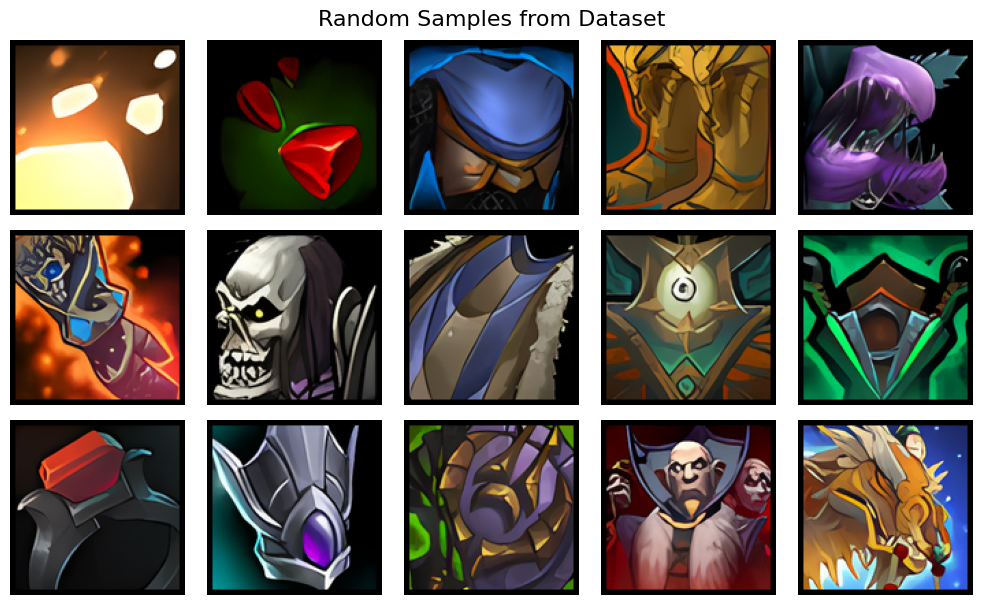

In [73]:
# display random samples from dataset
fig = plt.figure(figsize=(10, 10))

icons_list = os.listdir("./data/ICONS")
icons_list_sample = np.random.choice(icons_list, size=15)

for i, item in enumerate(icons_list_sample):
    icon_path = os.path.join("./data/ICONS", item)
    icon_image = Image.open(icon_path)
    plt.subplot(5, 5, i + 1)
    plt.imshow(icon_image)
    plt.axis("off")

fig.suptitle("Random Samples from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

## Forward Diffusion Process Implementation

This section implements the forward diffusion process for our generative model. The implementation gradually adds noise to WoW icons, transforming clean images into pure noise through a controlled process.

The visualization function below shows this process by displaying several random icons from our dataset, with each row showing the progressive application of noise along the x-axis. This visualization helps us understand how the diffusion process gradually destroys the original image structure at different timesteps.


## Forward Diffusion Process Explained

The forward diffusion process gradually adds noise to an image over a series of timesteps. Let's break down the key components:

### Noise Schedule Function

```python
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)
```

This function creates a linear schedule for the noise variance (β) at each timestep:

- Starts with minimal noise (`start=0.0001`)
- Gradually increases to larger noise (`end=0.02`)
- Creates `timesteps` evenly spaced values
- The schedule controls how quickly information is destroyed during diffusion

### Helper Function for Batch Processing

```python
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
```

This utility function:

- Extracts specific values from a parameter tensor based on timestep indices
- Reshapes the output to properly broadcast across the image dimensions
- Ensures values are on the correct device for computation
- Enables efficient batch processing of images at different timesteps

### Forward Diffusion Function

```python
def forward_diffusion_sample(x_0, t, device="mps"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(
        device
    ) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
```

This implements the core diffusion equation from Ho et al. (2020):

$$q(x_t|x_0) = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1-\bar{\alpha}_t} \cdot \epsilon$$

Where:

- $x_0$ is the original image
- $x_t$ is the noisy image at timestep $t$
- $\epsilon$ is random Gaussian noise
- $\bar{\alpha}_t$ represents how much of the original signal remains at timestep $t$

### Pre-calculated Diffusion Parameters

```python
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
```

These calculations:

- Set up the full noise schedule for all timesteps
- Pre-compute constants needed for both forward diffusion and the eventual reverse process
- Define how the signal-to-noise ratio changes at each step of the diffusion
- Calculate the posterior variance needed for the sampling process

The mathematical setup follows the DDPM paper (Ho et al., 2020), where:

- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$

These pre-calculations allow for efficient training and sampling as we don't need to recompute these values repeatedly.


In [35]:
import torch.nn.functional as F


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)


def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device="mps"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(
        device
    ) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

## Dataset and Data Loading Pipeline

This section sets up the data loading pipeline for our WoW icons dataset. <br>
It handles loading the TGA image files, preprocessing them, and creating batches for training.


In [46]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

IMG_SIZE = 64
BATCH_SIZE = 128


class WoWIconsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with the TGA files
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = [f for f in os.listdir(root_dir) if f.endswith(".tga")]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        # PIL can open TGA files
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image


def load_transformed_dataset(data_dir):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1),  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    dataset = WoWIconsDataset(root_dir=data_dir, transform=data_transform)
    return dataset


def show_tensor_image(image):
    # First move tensor to CPU before transformations
    if image.device.type != "cpu":
        image = image.cpu()

    reverse_transforms = transforms.Compose(
        [
            transforms.Lambda(lambda t: (t + 1) / 2),
            transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
            transforms.Lambda(lambda t: t * 255.0),
            transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ]
    )

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


# Assuming your extracted TGA files are in a directory called "wow_icons"
data_dir = "./data/ICONS"
data = load_transformed_dataset(data_dir)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## Display a sample


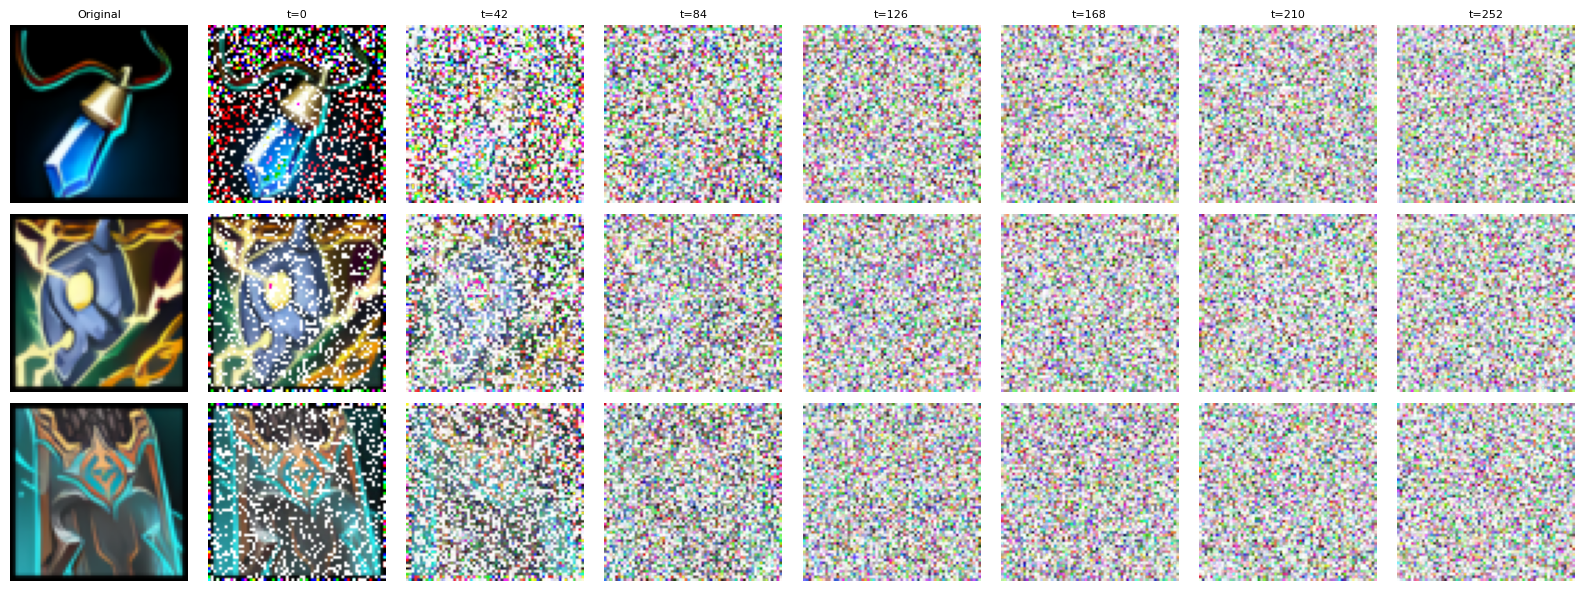

In [76]:
def display_icons_with_diffusion(
    dataloader, num_icons=3, num_steps=7, T=300, device="mps"
):
    """
    Display a grid of randomly selected icons with the diffusion process applied.
    Each row shows one icon progressively diffused with noise from left to right.
    The first column shows the original, unmodified icon.

    Args:
        dataloader: PyTorch dataloader containing the icon dataset
        num_icons: Number of different icons to display (rows)
        num_steps: Number of diffusion steps to display (not including original)
        T: Total number of timesteps in the diffusion process
        device: Device to run computations on
    """
    # Get a batch of images
    batch = next(iter(dataloader))

    # Create figure
    plt.figure(figsize=((num_steps + 1) * 2, num_icons * 2))

    # Get random indices from the batch
    batch_size = batch.shape[0]
    indices = np.random.choice(batch_size, size=num_icons, replace=False)

    # Calculate the step size between diffusion steps
    stepsize = int(T / num_steps)

    # Plot each selected image with different noise levels
    for row, idx in enumerate(indices):
        # Get the original image
        original_img = batch[idx].unsqueeze(0)  # Add batch dimension

        # First, display the original image with no noise
        plt.subplot(num_icons, num_steps + 1, row * (num_steps + 1) + 1)
        plt.axis("off")

        if original_img.device.type != "cpu":
            original_display = original_img.cpu()
        else:
            original_display = original_img

        show_tensor_image(original_display)

        # Add "Original" as title for the first row
        if row == 0:
            plt.title("Original", fontsize=8)

        # Apply different levels of noise for the remaining columns
        for col, timestep in enumerate(range(0, T, stepsize)):
            if col >= num_steps:
                break

            plt.subplot(
                num_icons, num_steps + 1, row * (num_steps + 1) + col + 2
            )  # +2 because we already used column 1
            plt.axis("off")

            # Apply forward diffusion with current timestep
            t = torch.tensor([timestep], device=device).type(torch.int64)
            noisy_img, _ = forward_diffusion_sample(original_img, t, device=device)

            # Display the image
            if noisy_img.device.type != "cpu":
                noisy_img = noisy_img.cpu()

            show_tensor_image(noisy_img)

            # Add timestep as title for the first row
            if row == 0:
                plt.title(f"t={timestep}", fontsize=8)

    plt.tight_layout()
    plt.show()


# Usage example
display_icons_with_diffusion(dataloader, num_icons=3, num_steps=7)